In [ ]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

debug = False
seed = 345
np.random.seed(seed)
torch.manual_seed(seed)
case = '0.01'

# exact solution
def exact_solution(x, param = 6.0):
    return torch.pow(torch.sin(param * x),3)


warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})
sns.set_style("whitegrid")

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 1
        self.numParams = 1
        self.numOutputs = 1
        self.hidden_size = 50

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = None
        self.mean_predicted_params = None
        self.mu = torch.tensor([3.0], device=self.device).requires_grad_(True)
        self.var = torch.tensor([1.0], device=self.device).requires_grad_(True)


        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, 2*self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, 2*self.numParams).to(self.device)
        # self.t3.weight.data.normal_(5.0, 0.1)
        self.act = nn.Tanh()
        #self.layerNorm = nn.LayerNorm(self.numParams).to(self.device)
        # self.layerNorm = nn.BatchNorm1d(self.numParams).to(self.device)


    def create_dataset(self, noise_scale=0.01, num_samples=16):
        
        # Generate x and y points evenly spaced between -1 and 1
        x1 = torch.linspace(-0.8, -0.2, num_samples, device=self.device)  
        x2 = torch.linspace(0.2, 0.8, num_samples, device=self.device)

        self.sensor_x = torch.cat([x1, x2]).requires_grad_(True)
        # self.sensor_x = torch.linspace(-1, 1, num_samples, device=self.device).requires_grad_(True)
        self.sensor_u = exact_solution(self.sensor_x) + torch.randn(self.sensor_x.shape[0], device=self.device) * noise_scale


    def forward(self, x):
        # if not torch.is_tensor(x):
        #     x = torch.from_numpy(x).float().to(self.device)


        # Add a dimension if it's not already there
        x = x.unsqueeze(1) if x.dim() == 1 else x


        h1 = self.act(self.b1(x))
        h2 = self.act(self.b2(h1))

        t2 = self.sample_posterior(x)

        u = self.b3(torch.multiply(t2, h2))
        if debug:

             print('shape of using:', u.shape)
        # u = self.b3(h2)

        return u[:,0], u[:,1]


    def sample_posterior(self, x):
        prior = torch.rand(x.shape[0], self.hidden_size, device=self.device).requires_grad_(True)
        # prior = torch.tile(x, (1, self.hidden_size)).reshape(x.shape[0], self.hidden_size).requires_grad_(True)
        #prior_param_samples = 0*h2
        # Sample the parameter posterior and update self.predicted_params and self.std_params
                
        t1 = self.act(self.t1(prior))
        t2 = self.act(self.t2(t1))
        pert = self.t3(t2)
        mu = 2.0+ pert[:,0]
        var = torch.exp(pert[:,1])
        posterior_samples = mu + prior.mean(dim=1)*var
        #posterior_samples = self.mu + prior.mean(dim=1)*self.var
        # print('shape of posterior_samples:', posterior_samples.shape)
        
        self.update_predicted_params(posterior_samples)
        return t2

    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)


    def PDE_residual(self, x):
        u, log_var = self.forward(x)
        
        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        if debug:
            print('shape of u:', u.shape, 'shape pf predicted params:', self.predicted_params.shape)
        
        residual = u.flatten() - torch.pow(torch.sin(self.mean_predicted_params * x), 3).flatten()
       
        if debug:
            print('shape of residual:', residual.shape)
        return residual,log_var


    
    def loss_interior(self, num_samples=500):
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res1,log_var = self.PDE_residual(interior_x_samples)
        #loss_residual1 = torch.mean(torch.square(res1))
        loss_residual1 = ngll(res1, torch.zeros_like(res1), torch.exp(log_var))
        return loss_residual1 


    def loss_data(self):
        u_pred, log_var = self.forward(self.sensor_x)
        # error = torch.square(u_pred.squeeze() - self.sensor_u)
        # loss_u = torch.mean(error)
        loss_u = ngll(u_pred, self.sensor_u, torch.exp(log_var))
        return loss_u

    def compute_losses(self):
        loss_interior = self.loss_interior(num_samples=500)
        loss_data = self.loss_data()
        return loss_interior, loss_data

    def update_predicted_params(self, posterior_samples):
        self.predicted_params = posterior_samples
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data = self.compute_losses()
        total_loss = self.w_int * loss_interior \
                    + self.w_data * loss_data 




        # Add the (Log(std))**2 term to the loss with the specified weight
        # Add the (Log(w * std))**2 term to the loss with the specified weight
        # self.log_std_squared_loss = torch.mean(torch.log(self.w_param_std * self.std_params)**2)
    
        # self.log_std_squared_loss =  self.w_param_std*(torch.exp(-torch.abs(self.mean_predicted_params)) - torch.log(self.std_params)) 
        # self.log_std_squared_loss =  self.w_param_std*(- torch.log(self.predicted_params.std(dim=0))) 
        self.log_std_squared_loss =  - self.w_param_std*self.std_params
        # total_loss += self.log_std_squared_loss.item()
        


        total_loss.backward(retain_graph=True)

        
        return total_loss


    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=10, verbose=True)


        # Training loop
#         for epoch in range(epochs):
        for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
            self.optimizer.step(self.closure)
            if epoch % 200 == 0:
                loss_interior, loss_data = self.compute_losses()
                
                total_loss =  loss_data  

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_interior_history.append(loss_interior.item())
                self.loss_data_history.append(loss_data.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():g}  ' \
                        f'PDE Loss:{loss_interior.item():.4f}  ' \
                        f'Data Loss: {loss_data.item():.4f}  ' \
                        f'Mean Predicted Param 1: {self.mean_predicted_params:.4f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy():.4f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.4f}')

In [3]:
ngll = torch.nn.GaussianNLLLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [4]:
def make_plot(model, device=device):
    # Generate test data
    num_test_samples = 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device).unsqueeze(1)
    

    model.eval()
    with torch.no_grad():
        u_preds, log_vars = model.forward(x_test)
  
    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_test)

    # Create plots
    

    fig, ax = plt.subplots()

    
    # Plot predicted 'u'
    ax.plot(x_test.cpu().numpy(),u_preds.cpu().numpy(), label='Predicted')
    # Plot exact 'u'
    ax.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
    ax.plot(model.sensor_x.cpu().detach().numpy(), model.sensor_u.cpu().detach().numpy(), 'o', alpha=0.5, label='Data')


    plt.tight_layout()
    # plt.savefig('result_plot.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.legend()
    plt.show()
    return ax

In [5]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

mps
Params: 7954


In [6]:
net.create_dataset(num_samples=32)

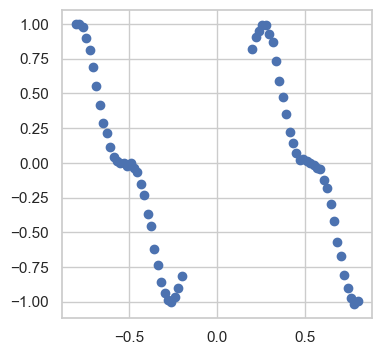

In [7]:
plt.plot(net.sensor_x.cpu().detach().numpy(), net.sensor_u.cpu().detach().numpy(), 'o')

In [8]:
net.w_int = 3000
net.w_data = 5000
net.w_bc   = 0
net.w_param_std = 0

In [9]:
# high noise
# net.w_int = 1000
# net.w_data = 5000
# net.w_bc   = 0
# net.w_param_std = 0

In [10]:
torch.autograd.set_detect_anomaly(True)
net.train(5000, optimizer='Adam', lr=5e-3)

Training Progress:   0%|          | 3/5000 [00:00<13:35,  6.13epoch/s]

Epoch(Adam):0,  Total Loss:0.202919  PDE Loss:0.1427  Data Loss: 0.2029  Mean Predicted Param 1: 2.6977 Std Params:0.0879  Std Log Loss:0.0000


Training Progress:   4%|▍         | 203/5000 [00:10<04:08, 19.29epoch/s]

Epoch(Adam):200,  Total Loss:-1.87035  PDE Loss:-0.9651  Data Loss: -1.8703  Mean Predicted Param 1: 5.9126 Std Params:0.0415  Std Log Loss:0.0000


Training Progress:   8%|▊         | 401/5000 [00:20<03:50, 19.96epoch/s]


Epoch(Adam):400,  Total Loss:-1.34028  PDE Loss:-0.9138  Data Loss: -1.3403  Mean Predicted Param 1: 5.9394 Std Params:0.0142  Std Log Loss:0.0000


KeyboardInterrupt: 

Training Progress: 0epoch [00:00, ?epoch/s]


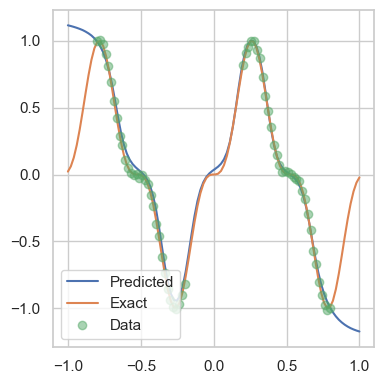

In [11]:
ax = make_plot(net, device=net.device)

In [12]:
def plot_loss_history(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, net.total_loss_history, label='Total Loss')
    plt.plot(epochs, net.loss_interior_history, label='Interior Loss')
    plt.plot(epochs, net.loss_data_history, label='Data Loss')
    plt.plot(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.tight_layout()
    plt.savefig('2d_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()


def plot_loss_history_log(net):
    epochs = range(len(net.total_loss_history))

    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, net.total_loss_history, label='Total Loss')
    plt.semilogy(epochs, net.loss_interior_history, label='Interior Loss')
    plt.semilogy(epochs, net.loss_data_history, label='Data Loss')
    plt.semilogy(epochs, net.loss_std_history, label='STD Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
#     plt.legend()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('2d_log_loss.png', dpi=400)  # Save the figure as a PNG file with 400 DPI
    plt.show()

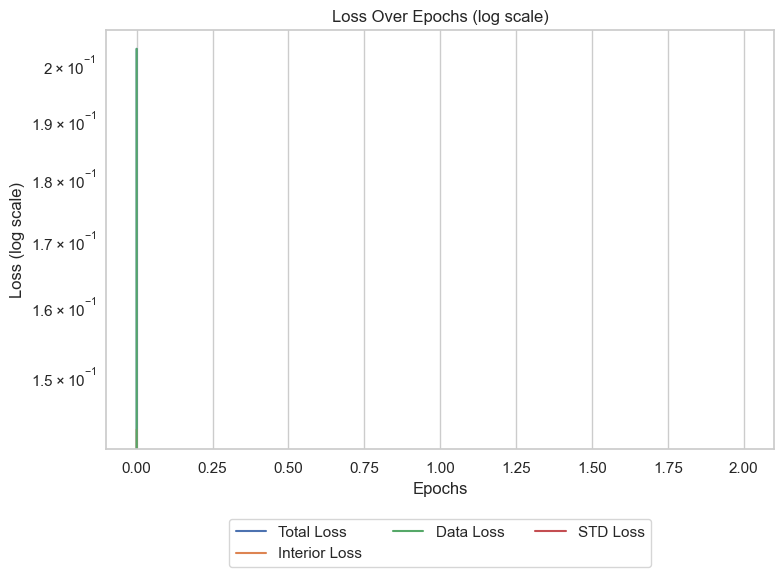

In [13]:
plot_loss_history_log(net)

In [14]:
plt.rcParams.update({
    'lines.linewidth': 3,      # Default line width for plots
    'font.size': 20,           # Minimum font size for all text elements
    'axes.titlesize': 20,      # Title font size
    'axes.labelsize': 20,      # Axis label font size
    'xtick.labelsize': 20,     # X-axis tick label font size
    'ytick.labelsize': 20,     # Y-axis tick label font size
    'legend.fontsize': 16,     # Legend font size
})

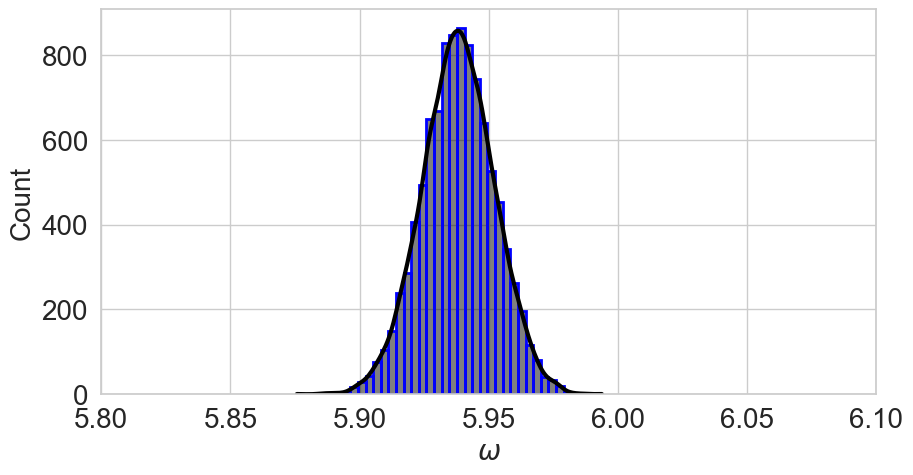

In [16]:
param_name = r'$\omega$'

_ = net.sample_posterior(torch.linspace(-1, 1, 10000, device=net.device))
samples = net.predicted_params.detach().cpu().numpy()
samples = samples.reshape(-1, 1)

#samples = net.predicted_params.detach().cpu().numpy()
df = pd.DataFrame(samples, columns=[param_name])

plt.figure(figsize=(10, 5))  # Adjust size as needed for a single plot
sns.histplot(df[param_name], kde=True, linewidth=2, edgecolor='blue',
             color='black', bins =40 )
# plt.title('Parameter Distribution')
plt.xlim([5.8, 6.1])
plt.savefig('sin_dist_'+case+'.png', dpi=400,  bbox_inches='tight')  # Save the figure as a PNG file with 400 DPI
plt.show()

**Testing the residual plot for the whole batch of data**

In [159]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(samples)
print(gm.means_)

[[5.99524633]
 [5.99524633]]


In [160]:
def plot_uncertainty(model, device=device):
    # Generate test data
    num_test_samples = 100
    num_tests= 100
    x_test = torch.linspace(-1, 1, num_test_samples, device=device)
   

    x_flat = x_test.reshape(-1)

    u_preds = []
    vars = []

    model.eval()
    with torch.no_grad():
        for i in range(num_tests):


            # Slice the batch
            x_batch = x_flat
   

            # Predict for this batch
            u_pred, log_vars = model.forward(x_batch)

            # Collect predictions
            u_preds.append(u_pred)
            vars.append(log_vars.exp())
    

    # Concatenate all batched predictions
    u_preds = torch.stack(u_preds)
    u_mean = u_preds.mean(dim=0)
    u_std = u_preds.std(dim=0)
    vars = torch.stack(vars)
    vars_mean = vars.mean(dim=0)
    std = 1*vars_mean.sqrt() + 1*u_std



    # Reshape predictions to match the grid shap

    # Compute the exact solutions for comparison
    u_exact = exact_solution(x_test)


    # Compute error
    u_error = torch.abs(u_mean - u_exact)

    # Plotting
    fig, axes = plt.subplots(1, 1, figsize=(9 , 5))
    axes.plot(x_test.cpu().numpy(), u_mean.cpu().numpy(), label='Predicted')
    axes.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
    axes.fill_between(x_flat.cpu().numpy(), (u_mean - 2*std).cpu().numpy().flatten(),
                       (u_mean + 2*std).cpu().numpy().flatten(), alpha=0.5, label='Uncertainty')
    axes.scatter(model.sensor_x.cpu().detach().numpy(), model.sensor_u.cpu().detach().numpy(), color='black', label='Data')
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=False)
    



    

Training Progress: 0epoch [00:00, ?epoch/s]


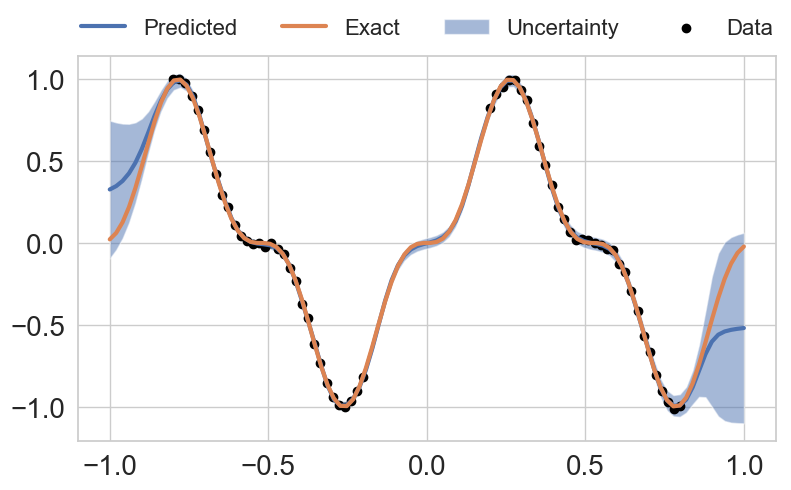

In [161]:
plot_uncertainty(net)
plt.savefig('sin_uncertainty_'+case+'.png', dpi=400,  bbox_inches='tight')  # Save the figure as a PNG file with 400 DPI

In [58]:
# plot_posterior_mean_errors(net)

In [59]:
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': net.optimizer.state_dict(),
    'total_loss_history': net.total_loss_history,
    'loss_interior_history': net.loss_interior_history,
    'loss_data_history': net.loss_data_history,
    'loss_bc_history': net.loss_bc_history,
    'loss_std_history': net.loss_std_history
    # Add other variables if needed
}, f'model_checkpoint_sin_'+case+'.pth')

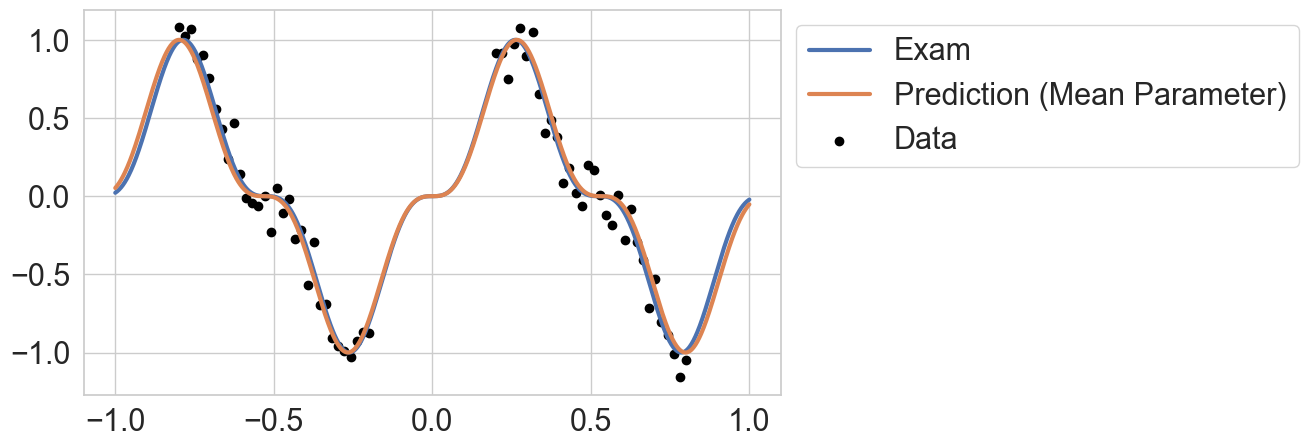

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(9 , 5))
x_test = torch.linspace(-1, 1, 1000, device=device).unsqueeze(1)
plt.plot(x_test.cpu().numpy(), exact_solution(x_test, param=6.0).cpu().numpy(), label='Exam')
plt.plot(x_test.cpu().numpy(), exact_solution(x_test, param=5.9).cpu().numpy(), label='Prediction (Mean Parameter)')
plt.scatter(net.sensor_x.cpu().detach().numpy(), net.sensor_u.cpu().detach().numpy(), color='black' , label='Data')
plt.legend(loc= 'upper left', bbox_to_anchor=(1,1))
plt.savefig('sin_param_'+case+'.png', dpi=400,  bbox_inches='tight')  # Save the figure as a PNG file with 400 DPI

In [61]:
res_test, _ = net.PDE_residual(x_test)
u_pred, _ = net.forward(x_test)


In [62]:
res_test.shape

torch.Size([1000])

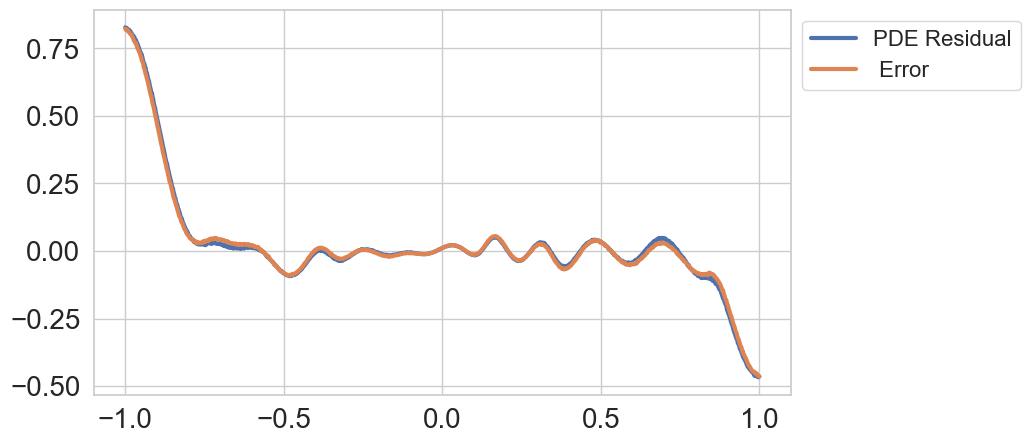

In [162]:
fig, axes = plt.subplots(1, 1, figsize=(9 , 5))
plt.plot(x_test.cpu().numpy(), res_test.cpu().detach().numpy(), label='PDE Residual')
plt.plot(x_test.cpu().numpy(), u_pred.cpu().detach().numpy().flatten() - exact_solution(x_test).cpu().numpy().flatten(),
          label=' Error')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('sin_residual_'+case+'.png', dpi=400,  bbox_inches='tight')  # Save the figure as a PNG file with 400 DPI